In [23]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from torchsummary import summary

from utils.data_utils import *
from model.encoder import Encoder
from model.generator import Generator

import matplotlib.pyplot as plt

# Args

In [6]:
choose_cuda = True
data_dir = '/home/ewok261/Documents/psychic-gan/data/in_2_out_1_ol_0'
frm_in = 2
frm_out = 1
mini_batch = 32
n_epochs = 100

In [7]:
if choose_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


# Load data

In [8]:
all_data = KITTIData(frm_in, frm_out, 0, data_dir)
[train_data,val_data] = data.random_split(all_data, [1100, 243])
[train_data, _] = data.random_split(train_data, [1, 1099]) # take a small subset of training data (for overfitting)
[val_data, _] = data.random_split(val_data, [3, 240])
train_loader = data.DataLoader(train_data, batch_size = 1, shuffle=True, num_workers=1)
val_loader = data.DataLoader(val_data, batch_size = 1, shuffle = False, num_workers = 1)
print('Train size: {0}'.format(len(train_data)))
print('Val size: {0}'.format(len(val_data)))

Train size: 1
Val size: 3


# Define the network and loss

In [9]:
loss_fun = nn.MSELoss()

encoder = Encoder(frame_dim=64, init_temp=2, hidden_dim=128, out_filters=256,
                  attention_at=8, norm=nn.utils.weight_norm, residual=True)
encoder = encoder.to(device)
encoder_optim = optim.Adam(encoder.parameters(), betas=(0.9, 0.999))

generator = Generator(frame_dim=64, temporal_target=1, hidden_dim=128,
                      init_filters=256, attention_at=8, norm=nn.utils.weight_norm)
generator = generator.to(device)
generator_optim = optim.Adam(generator.parameters(), betas=(0.5, 0.999))

# Training loop

In [10]:
train_hist = []
val_hist = []
for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            in_frames, out_frames = data
            in_frames, out_frames = in_frames.to(device), out_frames.to(device)

            # zero the parameter gradients
            encoder_optim.zero_grad()
            generator_optim.zero_grad()

            # forward + backward + optimize
            #print(next(encoder.parameters()).is_cuda)
            #print(next(generator.parameters()).is_cuda)
            hidden, encoder_attn = encoder(in_frames)
            generated, generator_attn = generator(hidden)
            loss = loss_fun(generated, out_frames)

            loss.backward()
            generator_optim.step()
            encoder_optim.step()

            # print statistics
            running_loss += loss.item()# / 10
            #if i % 10 == 9:
            print('[Epoch {0} - Step {1}] Loss: {2}'.format(epoch, i, running_loss))
            train_hist.append(running_loss)
            running_loss = 0

        val_loss = 0.0
        for inval, outval in val_loader:
            # get the validation inputs and outputs
            inval, outval = inval.to(device), outval.to(device)

            # forward
            hidval, encval_attn = encoder(inval)
            genval, genval_attn = generator(hidval)
            val_loss += loss_fun(genval, outval).item() / len(val_loader)

        print('[Epoch {0}] Val-Loss: {1}'.format(epoch, val_loss))
        val_hist.append(val_loss)

[Epoch 0 - Step 0] Loss: 0.2168763428926468
[Epoch 0] Val-Loss: 0.22406098743279776
[Epoch 1 - Step 0] Loss: 0.1896727979183197
[Epoch 1] Val-Loss: 0.12277725090583165
[Epoch 2 - Step 0] Loss: 0.08237167447805405
[Epoch 2] Val-Loss: 2.7058293024698896
[Epoch 3 - Step 0] Loss: 2.231869697570801
[Epoch 3] Val-Loss: 0.18798781434694928
[Epoch 4 - Step 0] Loss: 0.10916315764188766
[Epoch 4] Val-Loss: 0.21478773653507233
[Epoch 5 - Step 0] Loss: 0.16791053116321564
[Epoch 5] Val-Loss: 0.2168028155962626
[Epoch 6 - Step 0] Loss: 0.17647665739059448
[Epoch 6] Val-Loss: 0.21394688884417215
[Epoch 7 - Step 0] Loss: 0.17675752937793732
[Epoch 7] Val-Loss: 0.20864220956961313
[Epoch 8 - Step 0] Loss: 0.1730315387248993
[Epoch 8] Val-Loss: 0.1984986166159312
[Epoch 9 - Step 0] Loss: 0.16359111666679382
[Epoch 9] Val-Loss: 0.17983755469322202
[Epoch 10 - Step 0] Loss: 0.14477765560150146
[Epoch 10] Val-Loss: 0.1505028878649076
[Epoch 11 - Step 0] Loss: 0.11256816238164902
[Epoch 11] Val-Loss: 0.123

[Epoch 94] Val-Loss: 0.15472887953122455
[Epoch 95 - Step 0] Loss: 0.012518885545432568
[Epoch 95] Val-Loss: 0.15365284432967502
[Epoch 96 - Step 0] Loss: 0.012611440382897854
[Epoch 96] Val-Loss: 0.16417719672123593
[Epoch 97 - Step 0] Loss: 0.012563052587211132
[Epoch 97] Val-Loss: 0.15444619208574295
[Epoch 98 - Step 0] Loss: 0.012507570907473564
[Epoch 98] Val-Loss: 0.16067439566055933
[Epoch 99 - Step 0] Loss: 0.0121221374720335
[Epoch 99] Val-Loss: 0.15706006934245426


# Results visualization

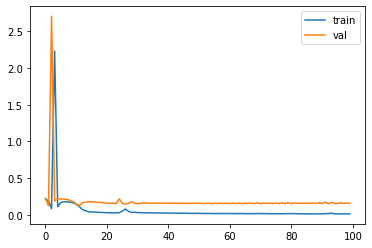

In [11]:
plt.plot(train_hist)
plt.plot(val_hist)
plt.legend(['train','val'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


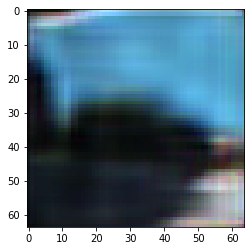

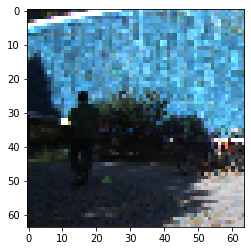

In [12]:
insamp, outsamp = train_data[0]
insamp = insamp.unsqueeze(0)
outsamp = outsamp.unsqueeze(0)
#print(insamp.shape)
#print(outsamp.shape)
insamp, outsamp = insamp.to(device), outsamp.to(device)
hidval, encval_attn = encoder(insamp)
genval, genval_attn = generator(hidval)

genval = genval.squeeze().permute(1,2,0).detach().numpy()
outsamp = outsamp.squeeze().permute(1,2,0).numpy()

plt.imshow(genval)
plt.show()
plt.imshow(outsamp)
plt.show()

In [13]:
encval_attn = encval_attn.squeeze().detach().numpy()
genval_attn = genval_attn.squeeze().detach().numpy()
print(encval_attn.shape)
print(genval_attn.shape)

(64, 8, 8)
(128, 8, 8)


In [25]:
summary(encoder, input_size=(3, 2, 64, 64))
summary(generator, input_size=(128, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 16, 1, 32, 32]           1,312
         LeakyReLU-2        [-1, 16, 1, 32, 32]               0
        NormConvND-3        [-1, 16, 1, 32, 32]               0
            Conv3d-4        [-1, 16, 1, 32, 32]              64
         LeakyReLU-5        [-1, 16, 1, 32, 32]               0
        NormConvND-6        [-1, 16, 1, 32, 32]               0
ResidualNormConv3D-7        [-1, 16, 1, 32, 32]               0
            Conv3d-8        [-1, 32, 1, 16, 16]          13,856
         LeakyReLU-9        [-1, 32, 1, 16, 16]               0
       NormConvND-10        [-1, 32, 1, 16, 16]               0
           Conv3d-11        [-1, 32, 1, 16, 16]             544
        LeakyReLU-12        [-1, 32, 1, 16, 16]               0
       NormConvND-13        [-1, 32, 1, 16, 16]               0
ResidualNormConv3D-14        [-1, 32, 1

In [15]:
print(encval_attn[0,:,:])

[[-0.11132722  0.02084559 -0.08078738 -0.19068544 -0.25577462 -0.14956722
  -0.33629906 -0.10770121]
 [-0.11131836  0.02085742 -0.08079305 -0.19068706 -0.25577503 -0.1495624
  -0.33631912 -0.1076926 ]
 [-0.11131924  0.02085938 -0.08080219 -0.19068603 -0.255772   -0.14956321
  -0.33631772 -0.10769217]
 [-0.11132014  0.02085513 -0.08079371 -0.19068664 -0.2557742  -0.14956358
  -0.33631453 -0.10769437]
 [-0.11131943  0.0208555  -0.08079185 -0.1906869  -0.25577495 -0.14956307
  -0.33631626 -0.10769391]
 [-0.11132041  0.0208571  -0.08080079 -0.1906862  -0.25577193 -0.1495631
  -0.33631516 -0.10769266]
 [-0.11132032  0.02085741 -0.08080016 -0.19068608 -0.25577232 -0.14956331
  -0.33631545 -0.10769303]
 [-0.11131896  0.02086931 -0.08082625 -0.19068372 -0.25576568 -0.14956333
  -0.33632243 -0.10768801]]


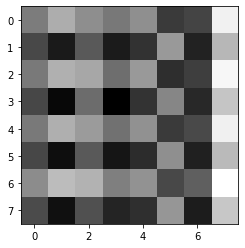

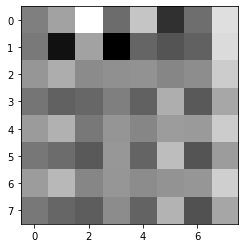

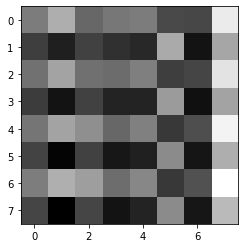

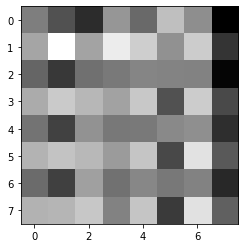

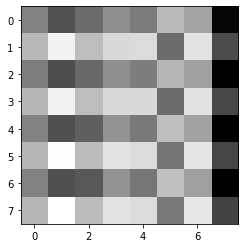

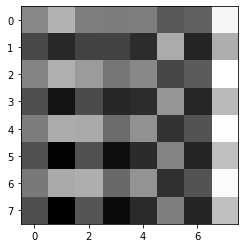

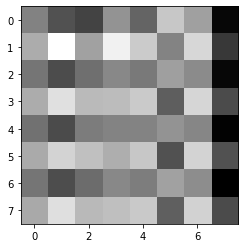

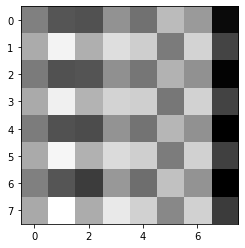

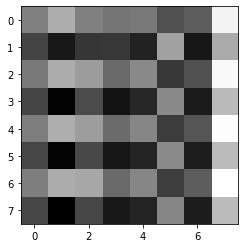

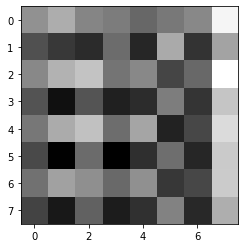

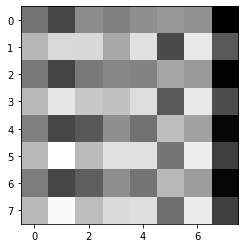

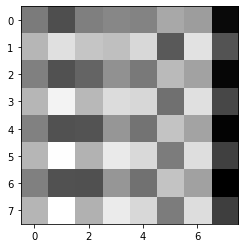

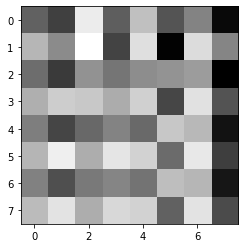

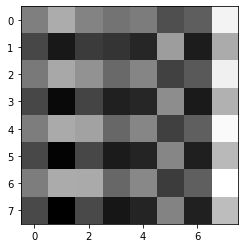

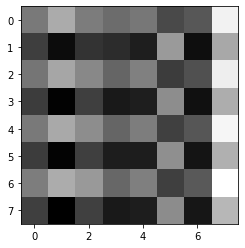

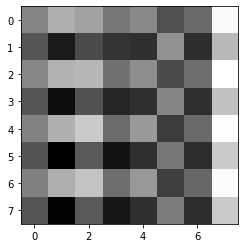

In [26]:
for idx in range(16):#genval_attn.shape[0]):
    plt.imshow(genval_attn[idx,:,:], cmap = 'gray')
    plt.show()

In [19]:
64*64

4096

In [20]:
4*4*256

4096